# Riemannian Score K-Means

In [24]:
#Modules

#jax
from jax import jacfwd, vmap
import jax.numpy as jnp
import jax.random as jrandom

#haiku
import haiku as hk

#os
import os

#numpy
import numpy as np

#matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as tkr

#other modules
from load_manifold import get_generator_dim, load_manifold

#scores
from models import models

#jaxgeometry
from jaxgeometry.statistics.score_matching import diffusion_mean as dm_score
from jaxgeometry.statistics.score_matching import model_loader
from jaxgeometry.statistics.score_matching import kmeans
from jaxgeometry.statistics.score_matching import ScoreEvaluation
from jaxgeometry.manifolds import *

In [12]:
#Hyper Parameters
T = 0.5
t0 = 0.01
score_path = "scores"
s2_approx = 0
s1loss_type = "dsmvr"
s2loss_type = "dsmvr"
s2_type = "s1s2"
seed = 2712
K = 4

figure_path = '../figures/ml_regression/'
if not os.path.exists(figure_path):
    os.makedirs(figure_path)

In [10]:
def load_score_model(manifold, dim):
    M, x0, sampling_method, generator_dim, layers, opt_val = load_manifold(manifold, dim)
    if "Local" in sampling_method:
        method = "Local"
    else:
        method = "Embedded"
    
    s1_path = ''.join((score_path, f"/{manifold}{dim}/s1T_{s1loss_type}/"))
    s2_path = ''.join((score_path, f"/{manifold}{dim}/{s2_type}T_{s2loss_type}/"))
    layers = get_generator_dim(generator_dim)

    s1_model = hk.transform(lambda x: models.MLP_s1(dim=generator_dim, layers=layers)(x))
    
    if s2_approx:
        if s2_type == "s2":
            s2_model = hk.transform(lambda x: models.MLP_s2(layers_alpha=layers, layers_beta=layers,
                                                            dim=generator_dim, r = max(generator_dim//2,1))(x))
        elif s2_type == "s1s2":
            @hk.transform
            def s2_model(x):

                s1s2 =  models.MLP_s1s2(
                    models.MLP_s1(dim=generator_dim, layers=layers), 
                    models.MLP_s2(layers_alpha=layers, 
                                  layers_beta=layers,
                                  dim=generator_dim,
                                  r = max(generator_dim//2,1))
                    )

                return s1s2(x)[1]
    else:
        s2_model = None
        
    s1_state = model_loader.load_model(s1_path)
    if s2_approx:
        s2_state = model_loader.load_model(s2_path)
    else:
        s2_state = None
    
    rng_key = jrandom.PRNGKey(seed)
    s1_fun = lambda x,y,t: s1_model.apply(s1_state.params, rng_key, jnp.hstack((x,y,t)))
    if s2_approx:
        s2_fun = lambda x,y,t: s2_model.apply(s2_state.params, rng_key, jnp.hstack((x,y,t)))
    else:
        s2_fun = None
        
    ScoreEval = ScoreEvaluation(M,
                                s1_model=s1_fun,
                                s2_model=s2_fun,
                                method = method
                                )
                       
    return M, x0, ScoreEval

## Testing with $\mathbb{R}^{2}$

In [11]:
M, x0, ScoreEval = load_score_model("Euclidean", 2)

using M.Exp for Logarithm


### Generate Test Data

In [68]:
eps = 0.1*np.random.normal(size=(100,2))
x = []
centers = [jnp.array([-1.0,0.0]), jnp.array([0.0,1.0]), jnp.array([1.0,0.0]), jnp.array([0.0,-1.0])]
for i in range(K):
    eps = 0.1*np.random.normal(size=(100,2))
    x.append(eps+centers[i])
x = jnp.vstack(x)

X_obs = (x, jnp.zeros(len(x)).reshape(-1))

### Testing with True Gradient

In [102]:
dist_fun = lambda x,y,t=t0: jnp.linalg.norm(t*M.grady_log_hk(x,y,t)[0])
dm_score(M, s1_model=lambda x,y,t: t*M.grady_log_hk(x,y,t)[0], s2_model = M.gradt_log_hk, method="Gradient")

def frechet_fun(X_obs, X_init, t=t0):
   
    mu = M.sm_dmx(X_obs, (X_init[0], X_init[1].reshape(-1)), t, step_size=0.01, max_iter=100)[0]
    
    return (mu[0][-1], mu[1][-1])

In [103]:
mu = M.sm_dmx(X_obs, (X_obs[0][0], X_obs[1][0].reshape(1)), t0, step_size=0.01, max_iter=100)[0]

In [104]:
RMK = kmeans.KMeans(dist_fun, frechet_fun, n_clusters=K, max_iter = 100)

In [105]:
RMK.fit(X_obs)

Iteration 1/100
Iteration 2/100
Iteration 3/100
Iteration 4/100
Iteration 5/100
Iteration 6/100
Iteration 7/100
Iteration 8/100
Iteration 9/100
Iteration 10/100
Iteration 11/100
Iteration 12/100
Iteration 13/100
Iteration 14/100
Iteration 15/100
Iteration 16/100
Iteration 17/100
Iteration 18/100
Iteration 19/100
Iteration 20/100
Iteration 21/100
Iteration 22/100
Iteration 23/100
Iteration 24/100
Iteration 25/100
Iteration 26/100
Iteration 27/100
Iteration 28/100
Iteration 29/100
Iteration 30/100
Iteration 31/100
Iteration 32/100
Iteration 33/100
Iteration 34/100
Iteration 35/100
Iteration 36/100
Iteration 37/100
Iteration 38/100
Iteration 39/100
Iteration 40/100
Iteration 41/100
Iteration 42/100
Iteration 43/100
Iteration 44/100
Iteration 45/100
Iteration 46/100
Iteration 47/100
Iteration 48/100
Iteration 49/100
Iteration 50/100
Iteration 51/100
Iteration 52/100
Iteration 53/100
Iteration 54/100
Iteration 55/100
Iteration 56/100
Iteration 57/100
Iteration 58/100
Iteration 59/100
Iterat

In [99]:
centroids, centroids_idx = RMK.centroids, RMK.centroid_idx

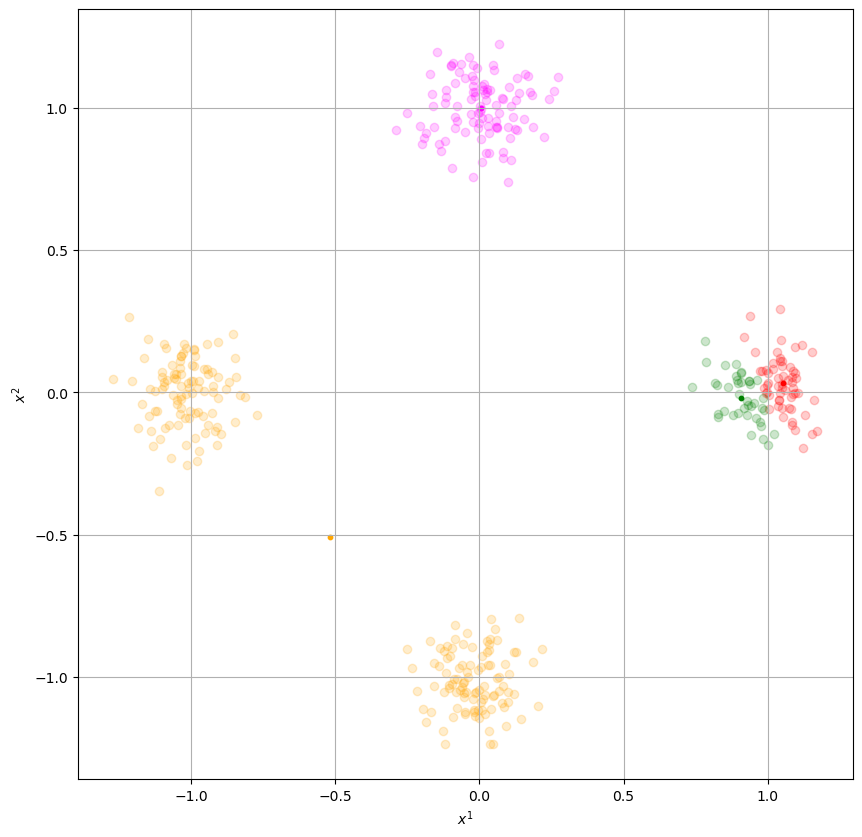

In [129]:
color = ['magenta', 'red', 'green', 'orange', "blue"]
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
for i in range(len(centroids_idx)):
    ax.scatter(centroids[0][i,0], centroids[0][i,1], alpha=1.0, s=10, color=color[i])
    ax.scatter(X_obs[0][centroids_idx[i],0], 
               X_obs[0][centroids_idx[i],1], alpha=0.2, color=color[i], label='Cluser ' + str(i+1))
ax.set_xlabel(r'$x^{1}$')
ax.set_ylabel(r'$x^{2}$')
ax.grid(True)

### Testing with True Gradient

In [123]:
dist_fun = lambda x,y,t=t0: jnp.linalg.norm(t*M.grady_log_hk(x,y,t)[0])
dm_score(M, s1_model=lambda x,y,t: t*ScoreEval.grady_log(x,y,t), s2_model = ScoreEval.gradt_log, method="Gradient")

def frechet_fun(X_obs, X_init, t=t0):
   
    mu = M.sm_dmx(X_obs, (X_init[0], X_init[1].reshape(-1)), t, step_size=0.01, max_iter=100)[0]
    
    return (mu[0][-1], mu[1][-1])

In [124]:
mu = M.sm_dmx(X_obs, (X_obs[0][0], X_obs[1][0].reshape(1)), t0, step_size=0.01, max_iter=1000)[0]

In [125]:
RMK = kmeans.KMeans(dist_fun, frechet_fun, n_clusters=K, max_iter = 100)

In [126]:
RMK.fit(X_obs)

Iteration 1/100
Iteration 2/100
Iteration 3/100
Iteration 4/100
Iteration 5/100
Iteration 6/100
Iteration 7/100
Iteration 8/100
Iteration 9/100
Iteration 10/100
Iteration 11/100
Iteration 12/100
Iteration 13/100
Iteration 14/100
Iteration 15/100
Iteration 16/100
Iteration 17/100
Iteration 18/100
Iteration 19/100
Iteration 20/100
Iteration 21/100
Iteration 22/100
Iteration 23/100
Iteration 24/100
Iteration 25/100
Iteration 26/100
Iteration 27/100
Iteration 28/100
Iteration 29/100
Iteration 30/100
Iteration 31/100
Iteration 32/100
Iteration 33/100
Iteration 34/100
Iteration 35/100
Iteration 36/100
Iteration 37/100
Iteration 38/100
Iteration 39/100
Iteration 40/100
Iteration 41/100
Iteration 42/100
Iteration 43/100
Iteration 44/100
Iteration 45/100
Iteration 46/100
Iteration 47/100
Iteration 48/100
Iteration 49/100
Iteration 50/100
Iteration 51/100
Iteration 52/100
Iteration 53/100
Iteration 54/100
Iteration 55/100
Iteration 56/100
Iteration 57/100
Iteration 58/100
Iteration 59/100
Iterat

In [127]:
centroids, centroids_idx = RMK.centroids, RMK.centroid_idx

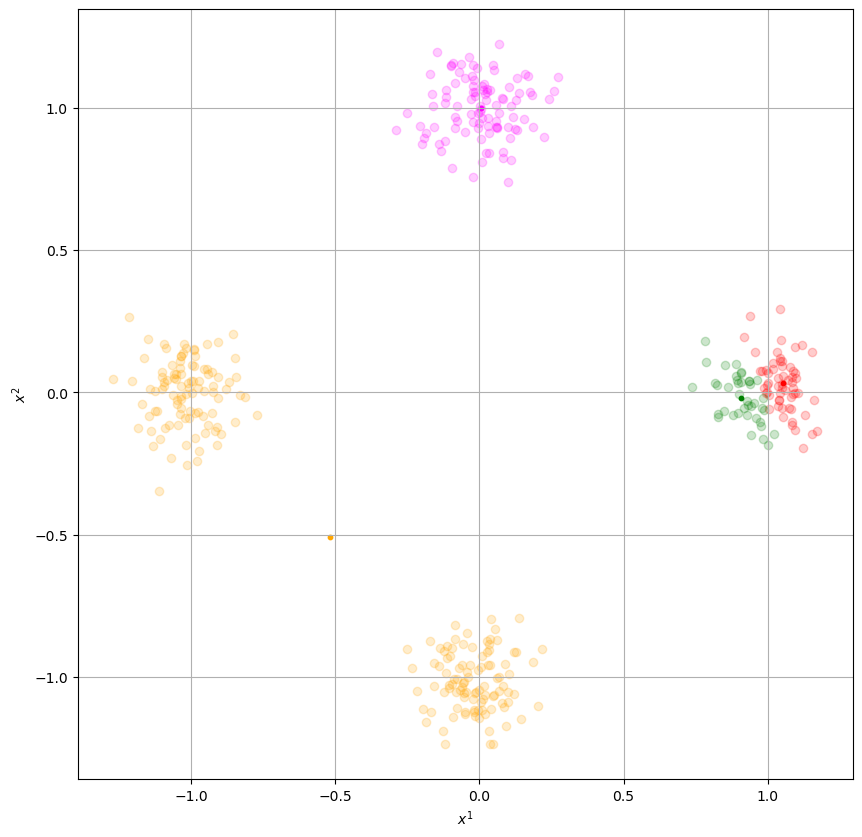

In [128]:
color = ['magenta', 'red', 'green', 'orange', "blue"]
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
for i in range(len(centroids_idx)):
    ax.scatter(centroids[0][i,0], centroids[0][i,1], alpha=1.0, s=10, color=color[i])
    ax.scatter(X_obs[0][centroids_idx[i],0], 
               X_obs[0][centroids_idx[i],1], alpha=0.2, color=color[i], label='Cluser ' + str(i+1))
ax.set_xlabel(r'$x^{1}$')
ax.set_ylabel(r'$x^{2}$')
ax.grid(True)

## Plotting Real-World Application